In [15]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [3]:
load_dotenv()

model = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")

In [4]:
class Evaluation(BaseModel):
    feedback : str = Field(description= "Detailed feedback for the essay")
    score : int = Field(description="Score out of 10", ge=0, le=10)

In [7]:
llm = model.with_structured_output(Evaluation)


In [27]:
essay = """
Taylor Swift: A Music Icon

Taylor Swift is one of the most influential artists in the world today. Born on December 13, 1989, in Reading, Pennsylvania, she showed an interest in music from a very young age. She started her career in country music, writing songs about love, heartbreak, and personal experiences. Her early albums, like Fearless and Speak Now, quickly made her a star.

Over time, Taylor Swift successfully transitioned from country to pop music, showing her versatility as an artist. Albums like 1989 and Reputation proved her ability to experiment with different sounds while keeping her songwriting at the center. She is known for writing her own lyrics, which makes her music feel personal and relatable to millions of fans around the world.

In addition to music, Taylor Swift has made a big impact on popular culture. She has won numerous awards, including multiple Grammys, and has broken many records in the music industry. She is also admired for standing up for artists’ rights, speaking out on important social issues, and using her platform to make a difference.

Taylor Swift is not just a singer—she is a storyteller. Through her songs, she has inspired people of all ages to embrace their emotions and stay true to themselves. Her journey from a young country singer to a global superstar is proof of her talent, hard work, and determination.
"""

In [12]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"

llm.invoke(prompt)

Evaluation(feedback="The essay provides a good overview of Taylor Swift's career and impact, but it contains numerous spelling and grammatical errors that detract significantly from its professionalism and readability. For example, 'influencial' should be 'influential', 'intrest' should be 'interest', 'Pennesylvania' should be 'Pennsylvania', 'contry' should be 'country', 'heartbrake' should be 'heartbreak', 'experences' should be 'experiences', 'albumbs' should be 'albums', 'succesfully' should be 'successfully', 'transistioned' should be 'transitioned', 'versatality' should be 'versatility', 'Reputaion' should be 'Reputation', 'diffrent' should be 'different', 'numorous' should be 'numerous', 'record’s' should be 'records', 'issue’s' should be 'issues', 'platfrom' should be 'platform', 'they’re' should be 'their', and 'themselfs' should be 'themselves'. Punctuation also needs attention, such as the missing comma after 'December 13 1989'. Improving these basic language mechanics would

In [16]:
class UPSCState(TypedDict):
    essay : str
    lang : str    # language feedback
    analysis : str    # analysis feedback
    clarity : str     # clarity feedback
    overall : str     # overall feedback
    individual_score : Annotated[list[int], operator.add]
    avg_score : float     

In [19]:
def eval_analysis(state: UPSCState):

    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"

    output = llm.invoke(prompt)

    return {"analysis" : output.feedback, 'individual_score': [output.score]}

In [20]:
def eval_lang(state: UPSCState):

    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"

    output = llm.invoke(prompt)

    return {"lang" : output.feedback, 'individual_score': [output.score]}

In [21]:
def eval_clarity(state: UPSCState):

    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"

    output = llm.invoke(prompt)

    return {"clarity" : output.feedback, 'individual_score': [output.score]}

In [22]:
def final_eval(state: UPSCState):

    prompt = f"Based on the following feedback, create a summarized feedback \nLanguage feedback - {state['lang']} \nDepth of analysis feedback - {state['analysis']} \nClarity of Thought - {state['clarity']}"

    overall = model.invoke(prompt).content

    avg_score = sum(state['individual_score'])/ len(state['individual_score'])

    return {"overall": overall, "avg_score": avg_score}

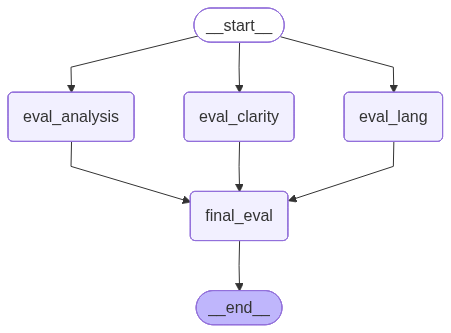

In [25]:
graph = StateGraph(UPSCState)

graph.add_node("eval_lang", eval_lang)
graph.add_node("eval_analysis", eval_analysis)
graph.add_node("eval_clarity", eval_clarity)
graph.add_node("final_eval", final_eval)

graph.add_edge(START, "eval_analysis")
graph.add_edge(START, "eval_lang")
graph.add_edge(START, "eval_clarity")

graph.add_edge("eval_analysis", "final_eval")
graph.add_edge("eval_lang", "final_eval")
graph.add_edge("eval_clarity", "final_eval")

graph.add_edge("final_eval", END)

workflow = graph.compile()
workflow


In [28]:
initial_state = {
    "essay" : essay
}

workflow.invoke(initial_state)

{'essay': '\nTaylor Swift: A Music Icon\n\nTaylor Swift is one of the most influential artists in the world today. Born on December 13, 1989, in Reading, Pennsylvania, she showed an interest in music from a very young age. She started her career in country music, writing songs about love, heartbreak, and personal experiences. Her early albums, like Fearless and Speak Now, quickly made her a star.\n\nOver time, Taylor Swift successfully transitioned from country to pop music, showing her versatility as an artist. Albums like 1989 and Reputation proved her ability to experiment with different sounds while keeping her songwriting at the center. She is known for writing her own lyrics, which makes her music feel personal and relatable to millions of fans around the world.\n\nIn addition to music, Taylor Swift has made a big impact on popular culture. She has won numerous awards, including multiple Grammys, and has broken many records in the music industry. She is also admired for standing 